In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/Arra1807/Inform_project_new.git

fatal: destination path 'Inform_project_new' already exists and is not an empty directory.


In [3]:
!nvidia-smi

Mon Aug 25 16:12:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Load Data

In [4]:
import numpy as np
from Inform_project_new.data.echosounder_data.load_data.get_echograms_2 import get_echograms, count_classes_in_echograms

# You can select a specific year or use 'all' to include multiple years.
years = 2014
minimum_shape = 224
tuple_frequencies = (18, 38, 70, 120, 200, 333)
echograms = get_echograms(years=years, tuple_frequencies=tuple_frequencies, minimum_shape=minimum_shape)
print(f"Number of echograms: {len(echograms)}")


Selected 10 echograms from year 2014
Number of echograms: 10


# Split Large Echograms into Train images and Test images

In [5]:
import os
import random
# Randomly split echograms into train/test
random.seed(42)  # Set a seed for reproducibility
Train_eg = []
test_eg = []
echogram = random.shuffle(echograms)  # Shuffle echograms randomly
for i,echogram in enumerate(echograms):
  if i < 0.8*len(echograms):
    Train_eg.append(echogram)
  else:
    test_eg.append(echogram)

#Save the echograms to files
train_dir = '/content/Inform_project_new/train'
test_dir = '/content/Inform_project_new/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for i, echogram in enumerate(Train_eg):
 os.path.join(train_dir, f'echogram_{i}.npy')
for i, echogram in enumerate(test_eg):
  os.path.join(test_dir, f'echogram_{i}.npy')

# Print the number of echograms in each set
print('Train Echogram:', len(Train_eg))
print('Test Echogram:', len(test_eg))

Train Echogram: 8
Test Echogram: 2


In [6]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import torch
import gc

# Manuell opprydding før trening
gc.collect()
torch.cuda.empty_cache()

# Sjekk og velg riktig device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Using device: cuda


In [7]:
from Inform_project_new.data.echosounder_data.preprocessing.resize_and_crop import SplitResizeEchogram, generate_patch_batches
from Inform_project_new.data.echosounder_data.preprocessing.normalization import db, clip, standardize_min_max


data_transform = [db, clip, standardize_min_max]
split_patch_size = 448
output_patch_size = 448


#---Train set---
train_generators, num_patches_per_train_echogram = generate_patch_batches(Train_eg, split_patch_size,
                                                                          output_patch_size, data_transforms= data_transform,
                                                                          batch_size='full', verbose= False)
print('Number of patches per echogram for training:', num_patches_per_train_echogram )

#---Test set---
generators_test, num_patches_per_test_echogram = generate_patch_batches(test_eg, split_patch_size, output_patch_size,
                                                                        data_transforms= data_transform,
                                                                        batch_size='full', verbose= False)
print('Number of patches per echogram for testing:', num_patches_per_train_echogram )

print('Number of generators:', len(train_generators))
print('Number of generators:', len(generators_test))


Number of patches per echogram for training: [np.int64(10), np.int64(9), np.int64(9), np.int64(21), np.int64(37), np.int64(7), np.int64(7), np.int64(8)]
Number of patches per echogram for testing: [np.int64(10), np.int64(9), np.int64(9), np.int64(21), np.int64(37), np.int64(7), np.int64(7), np.int64(8)]
Number of generators: 8
Number of generators: 2


# Dataloader

In [8]:
from Inform_project_new.data.echosounder_data.dataloader import BatchGeneratorDataset, GroupedGenerator, group_generators_by_patch_limit
from Inform_project_new.adaptation_method.model_config import Configuration
from torch.utils.data import DataLoader
import torch
import numpy as np


run = Configuration()
#---Training set---
print('-------Dimensions for Training set-------------')
grouped_generator_fns, grouped_patch_count = group_generators_by_patch_limit(train_generators,
                                                                             num_patches_per_train_echogram,
                                                                             20)
train_dataset = BatchGeneratorDataset(grouped_generator_fns)
train_loader = DataLoader(train_dataset, batch_size = None, pin_memory=True)
print(len(train_loader))
for label, data, mask in train_loader:
  print(data.shape)



wandb: Currently logged in as: arangan18 (arangan18-university-of-oslo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


-------Dimensions for Training set-------------
6
torch.Size([19, 6, 448, 448])
torch.Size([9, 6, 448, 448])
torch.Size([21, 6, 448, 448])
torch.Size([37, 6, 448, 448])
torch.Size([14, 6, 448, 448])
torch.Size([8, 6, 448, 448])


In [9]:
#---Test Set---
print('-------Dimensions for Test set-------------')
grouped_generator_fns_test, grouped_patch_count_test = group_generators_by_patch_limit(generators_test,
                                                                                       num_patches_per_test_echogram,
                                                                                       30)
test_dataset = BatchGeneratorDataset(grouped_generator_fns_test)

test_loader = DataLoader(test_dataset, batch_size = None, pin_memory= True)
for label, data, mask in test_loader:
  print(data.shape)



-------Dimensions for Test set-------------
torch.Size([16, 6, 448, 448])


In [10]:
torch.cuda.empty_cache()
!nvidia-smi

Mon Aug 25 16:13:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P0             31W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
"""
#from adaptation_method.train_autoencoder import train_val_encoder
from Inform_project_new.adaptation_method.train_autoencoder import train_val_encoder, plot_loss
from Inform_project_new.adaptation_method.Autoencoder import ResNetAutoEncoder
import torch.optim as optim
import torch.nn as nn

#For Logging
run = Configuration(model_name = 'ResNetAutoEncoder')

#Instantiating model
model = ResNetAutoEncoder()

# Defining Loss function and optimizer
Loss_func = nn.MSELoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr= run.config['learning_rate'],
                       weight_decay= run.config['Weight_decay']
)

encoded, avg_loss_train, val_encoded, avg_loss_val, epoch_stop = train_val_encoder(model, optimizer, Loss_func, run.config['epochs'], train_batched_loader, test_batched_loader, run)

plot_loss(run.config['epochs'], avg_loss_train, avg_loss_val, epoch_stop)
"""

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 203MB/s]


NameError: name 'train_batched_loader' is not defined

Epoch 1/10: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]


Train encodings: min=0.0130, max=0.9740
Val latents: min=0.0111, max=0.9778
 Train Loss = 0.0971 ,Validation Loss = 0.0570


Epoch 2/10: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


Train encodings: min=0.0388, max=0.9224
Val latents: min=0.0388, max=0.9224
 Train Loss = 0.0421 ,Validation Loss = 0.0320


Epoch 3/10: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


Train encodings: min=0.0685, max=0.8629
Val latents: min=0.0800, max=0.8401
 Train Loss = 0.0292 ,Validation Loss = 0.0240


Epoch 4/10: 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


Train encodings: min=0.0712, max=0.8577
Val latents: min=0.0754, max=0.8492
 Train Loss = 0.0254 ,Validation Loss = 0.0191


Epoch 5/10: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


Train encodings: min=0.0670, max=0.8660
Val latents: min=0.0696, max=0.8608
 Train Loss = 0.0229 ,Validation Loss = 0.0239


Epoch 6/10: 100%|██████████| 6/6 [00:03<00:00,  1.50it/s]


Train encodings: min=0.0510, max=0.8980
Val latents: min=0.0491, max=0.9018
 Train Loss = 0.0215 ,Validation Loss = 0.0230


Epoch 7/10: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Train encodings: min=0.0258, max=0.9484
Val latents: min=0.0233, max=0.9533
 Train Loss = 0.0201 ,Validation Loss = 0.0165


Epoch 8/10: 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]


Train encodings: min=0.0139, max=0.9721
Val latents: min=0.0129, max=0.9742
 Train Loss = 0.0193 ,Validation Loss = 0.0172


Epoch 9/10: 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


Train encodings: min=0.0126, max=0.9749
Val latents: min=0.0135, max=0.9731
 Train Loss = 0.0168 ,Validation Loss = 0.0161


Epoch 10/10: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


Train encodings: min=0.0315, max=0.9370
Val latents: min=0.0317, max=0.9366
 Train Loss = 0.0161 ,Validation Loss = 0.0131


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▄▃▂▃▃▂▂▁▁
epoch,10
train_loss,0.01608
val_loss,0.0131


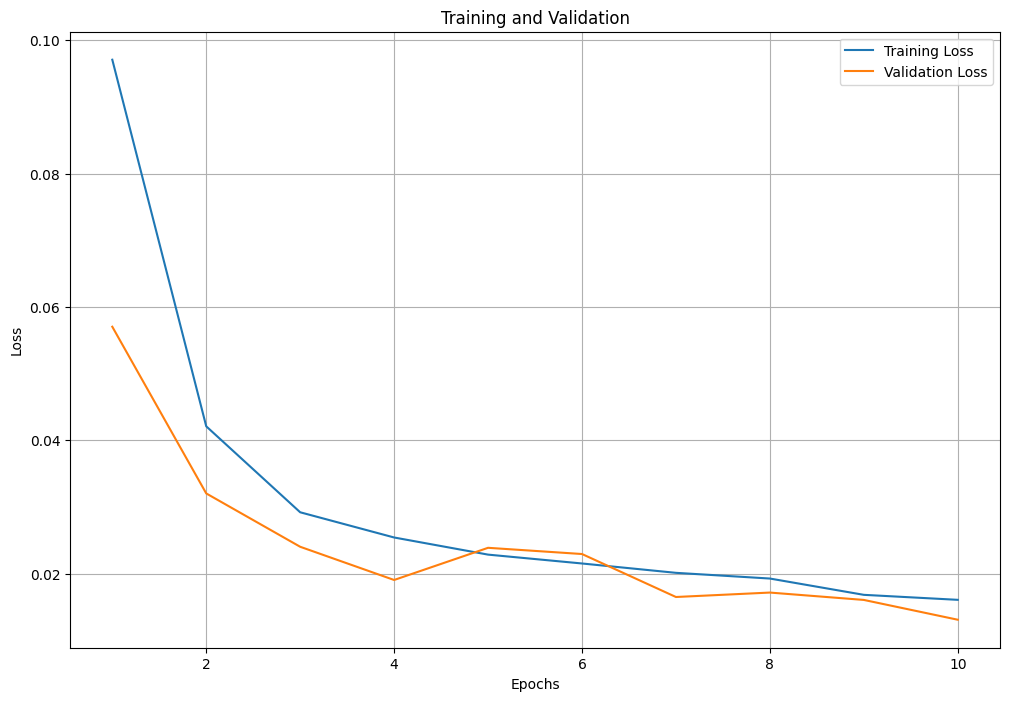

In [12]:
from Inform_project_new.adaptation_method.train_autoencoder import train_val_encoder, plot_loss
from Inform_project_new.adaptation_method.Autoencoder import Autoencoder
import torch.nn as nn
import torch.optim as optim

#For logging
run = Configuration(model_name = 'Autoencoder')

#Instantiating model
model = Autoencoder()



# Defining Loss function and optimizer
Loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = run.config['learning_rate'], weight_decay = run.config['Weight_decay'])

latent,  val_latent, avg_loss_train, avg_loss_val, stop_epoch = train_val_encoder(model, optimizer, Loss_func, run.config['epochs'], train_loader, test_loader, run)

plot_loss(run.config['epochs'], avg_loss_train, avg_loss_val, stop_epoch)


In [ ]:
encoder = latent.squeeze(0)
encoder_transpose = encoder.permute(2,1,0)
encoder = encoder_transpose.detach().numpy()
print(encoder.shape)

NameError: name 'latent' is not defined